In [3]:
import os
import fitz  # PyMuPDF for reading PDFs
import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Loading BERT Model...")
model = SentenceTransformer('all-MiniLM-L6-v2')
print("Model Loaded Successfully!")

Loading BERT Model...
Model Loaded Successfully!


In [4]:
# 1. Define the path to your main dataset folder
DATASET_PATH = r"C:\Users\vaibh\Downloads\Resumedata\data\data"

print("Starting PDF Extraction Pipeline...")
data = []

# Loop through every category folder (e.g., 'Java_Developer', 'HR_Manager')
for category_folder in os.listdir(DATASET_PATH):
    folder_path = os.path.join(DATASET_PATH, category_folder)
    
    # Ensure it's a folder, not a random file
    if os.path.isdir(folder_path):
        print(f"Reading PDFs from category: {category_folder}...")
        
        # Loop through every PDF inside that category folder
        for filename in os.listdir(folder_path):
            if filename.endswith(".pdf"):
                filepath = os.path.join(folder_path, filename)
                
                try:
                    # Open PDF and extract text using PyMuPDF
                    doc = fitz.open(filepath)
                    text = ""
                    for page in doc:
                        text += page.get_text()
                    
                    # Save the text and its label (the folder name)
                    data.append({"Category": category_folder, "Resume": text})
                    
                except Exception as e:
                    print(f"  -> Error reading {filename}: {e}")

# Convert our extracted data into a Pandas DataFrame
df = pd.DataFrame(data)
print(f"\nExtraction Complete! Total Resumes Loaded: {len(df)}")
print(f"Unique Job Categories: {df['Category'].nunique()}")

# 2. Fast Text Cleaning Function
def clean_resume_text(text):
    text = text.lower()
    text = re.sub('http\S+\s*', ' ', text)  # remove URLs
    text = re.sub('RT|cc', ' ', text)  # remove RT and cc
    text = re.sub('#\S+', '', text)  # remove hashtags
    text = re.sub('@\S+', '  ', text)  # remove mentions
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', text)  # remove punctuations
    text = re.sub(r'[^\x00-\x7f]',r' ', text) 
    text = re.sub('\s+', ' ', text)  # remove extra whitespace
    return text.strip()

# Apply cleaning
print("Cleaning extracted text data...")
df['Cleaned_Resume'] = df['Resume'].apply(clean_resume_text)
print("Text cleaning complete. You can now proceed to Cell 3!")

Starting PDF Extraction Pipeline...
Reading PDFs from category: ACCOUNTANT...
Reading PDFs from category: ADVOCATE...
Reading PDFs from category: AGRICULTURE...
Reading PDFs from category: APPAREL...
Reading PDFs from category: ARTS...
Reading PDFs from category: AUTOMOBILE...
Reading PDFs from category: AVIATION...
Reading PDFs from category: BANKING...
Reading PDFs from category: BPO...
Reading PDFs from category: BUSINESS-DEVELOPMENT...
Reading PDFs from category: CHEF...
Reading PDFs from category: CONSTRUCTION...
Reading PDFs from category: CONSULTANT...
Reading PDFs from category: DESIGNER...
Reading PDFs from category: DIGITAL-MEDIA...
Reading PDFs from category: ENGINEERING...
Reading PDFs from category: FINANCE...
Reading PDFs from category: FITNESS...
Reading PDFs from category: HEALTHCARE...
Reading PDFs from category: HR...
Reading PDFs from category: INFORMATION-TECHNOLOGY...
Reading PDFs from category: PUBLIC-RELATIONS...
Reading PDFs from category: SALES...
Reading PDFs 

In [5]:
print("Generating BERT Embeddings (This may take a few minutes)...")

# model.encode processes the whole list highly efficiently and shows a progress bar
X_embeddings = model.encode(df['Cleaned_Resume'].tolist(), show_progress_bar=True)

# Convert to a numpy array (Scikit-Learn requires this format)
X = np.array(X_embeddings)
print(f"Feature Matrix Shape (Resumes, Vector Dimensions): {X.shape}")

Generating BERT Embeddings (This may take a few minutes)...


Batches: 100%|███████████████████████████████████████████████████████████████████████| 78/78 [02:42<00:00,  2.08s/it]

Feature Matrix Shape (Resumes, Vector Dimensions): (2484, 384)


In [6]:
# Convert Text Categories into Numbers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Category'])

# Split the data: 80% for the model to learn, 20% to test if it actually learned
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")

Training Samples: 1987
Testing Samples: 497


In [7]:
print("Training Support Vector Classifier (SVC)...")

# Train the model
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

print("Training Complete!")

Training Support Vector Classifier (SVC)...
Training Complete!


In [8]:
# Ask the model to predict categories for the 20% test data it has never seen
y_pred = clf.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy * 100:.2f}%\n")

# Print detailed classification report
target_names = label_encoder.classes_
print(classification_report(y_test, y_pred, target_names=target_names))

Final Model Accuracy: 67.81%

                        precision    recall  f1-score   support

            ACCOUNTANT       0.79      0.79      0.79        24
              ADVOCATE       0.74      0.58      0.65        24
           AGRICULTURE       0.75      0.46      0.57        13
               APPAREL       0.55      0.32      0.40        19
                  ARTS       0.41      0.33      0.37        21
            AUTOMOBILE       1.00      0.14      0.25         7
              AVIATION       0.63      0.71      0.67        24
               BANKING       0.57      0.57      0.57        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.68      0.88      0.76        24
                  CHEF       0.91      0.83      0.87        24
          CONSTRUCTION       0.84      0.73      0.78        22
            CONSULTANT       0.73      0.83      0.78        23
              DESIGNER       0.82      0.67      0.74        21
         

P:\SmartHireAI\Backend\venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
P:\SmartHireAI\Backend\venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
P:\SmartHireAI\Backend\venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


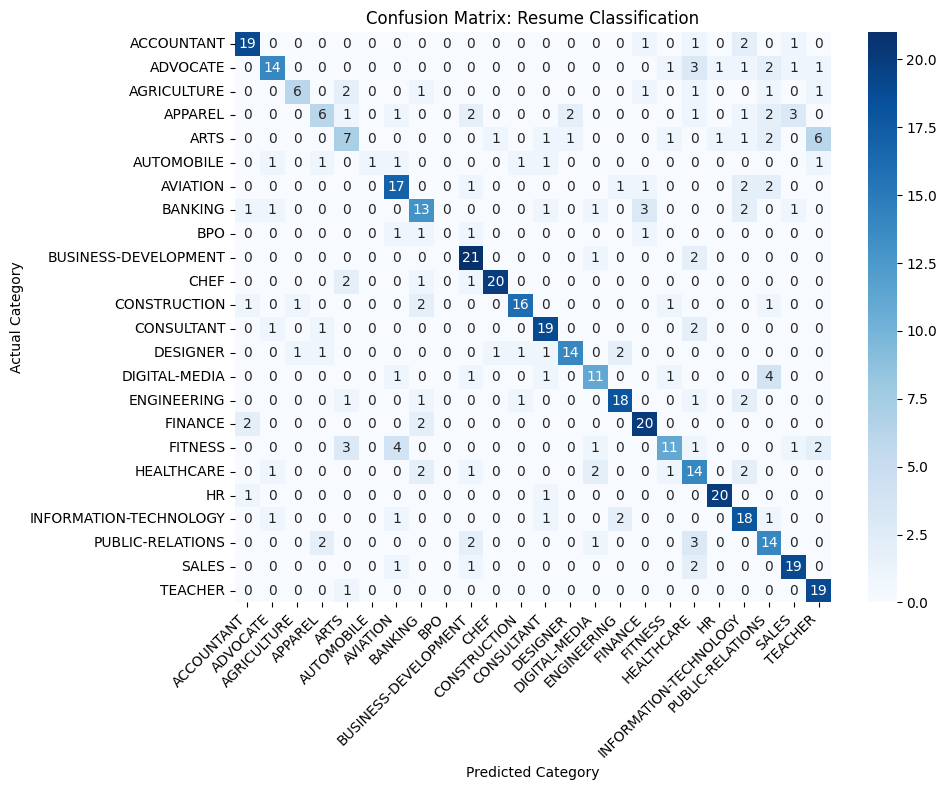

In [9]:
# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix: Resume Classification')
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
# Save the trained AI classifier
with open('resume_classifier_svm.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

# Save the label encoder (so the API knows which number maps back to which job title)
with open('label_encoder.pkl', 'wb') as encoder_file:
    pickle.dump(label_encoder, encoder_file)

print("Success! 'resume_classifier_svm.pkl' and 'label_encoder.pkl' saved to disk.")

Success! 'resume_classifier_svm.pkl' and 'label_encoder.pkl' saved to disk.
